# Main program to run different parts of the app

### Few Imports (The imports are yhen the function is called to avoid errors)

In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os

from bioml import Data_Selector as DS
from bioml import Feature_Extraction as FE
from bioml import Align_Streams as AS
from bioml import Data_Cutter as DC
from bioml import Data_PreProcessing as DPP
from bioml import DB_connection as DBC
from bioml import Data_Loader as DL
from bioml import Data_Generator as DG

#from bioml.models.functions import models_additional_functions as MAF #for step decay and grid search
from CNN_Ameri_like_model_2 import create_CNN_Ameri_like_model #the model

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error


import pandas as pd
import scipy.signal as sgn
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
exp = 'sleeve_corentin'

params = {
    'dbname': exp,
    'user': 'postgres',
    'host': '128.178.51.53',
    'port': 5432
    }

### Get available recordings

In [6]:
recs_dict = DS.get_recordings(params)
recs = [rec['label'] for rec in recs_dict]
print('Available recordings:', recs)

Available recordings: ['vincent_test_0']


### Define parameters to use

In [5]:
recs = ['vince_test_0']

channels = [[]]
for i in range(1,65):
    channels[0].append('HA-2015.08.05_channel{}'.format(i))
refs = [[]]

feature_names = [['MAV','WL','MaxAV','STD','ZC','SSC','RMS','WAMP','LOG','150_400']]

win_len = 200
step = 40

# Start pipeline

### Start by extracting data

In [8]:
#Connect
print('connect to DB')
engine, conn, cur, exp_info, subj_info = DBC.connect_DB(exp)

#Extract
print('Extract Data and Labels')
Tables, FSs = DL.H_extract_data(engine, recs, channels, refs, exp_info)
Labels, label_table_name = DL.H_load_labels(engine, cur, recs)

connect to DB
Extract Data and Labels
[('Right_Hand',)]


### Plot Raw Data

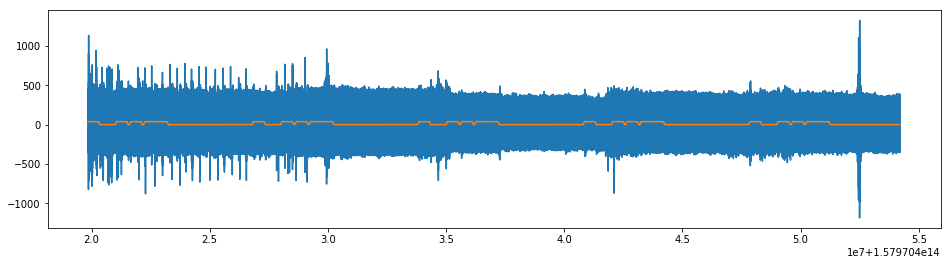

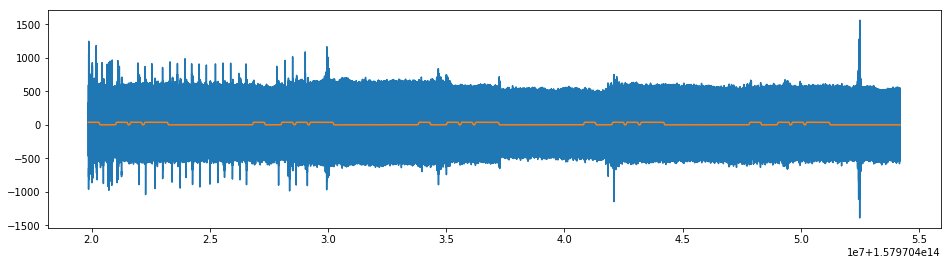

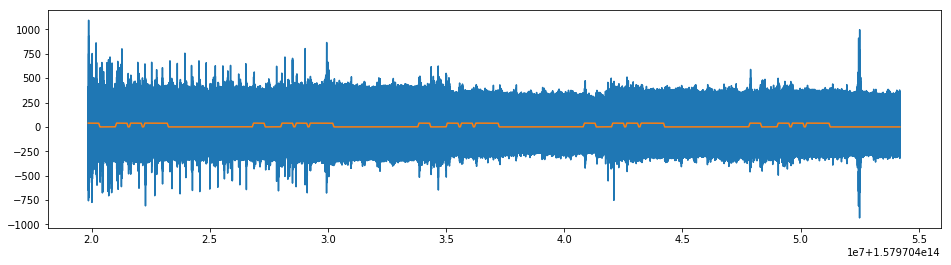

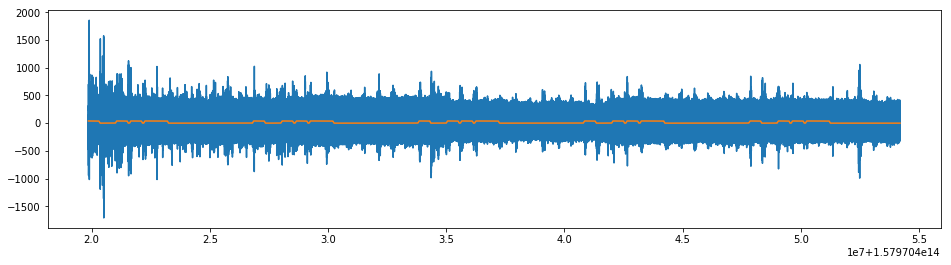

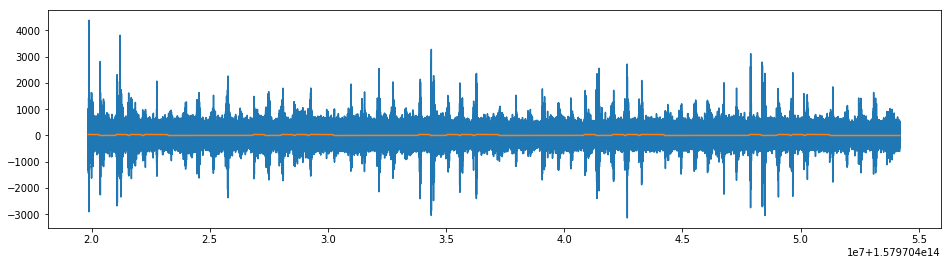

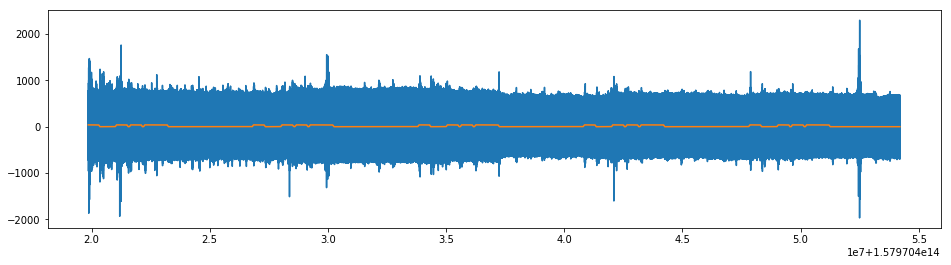

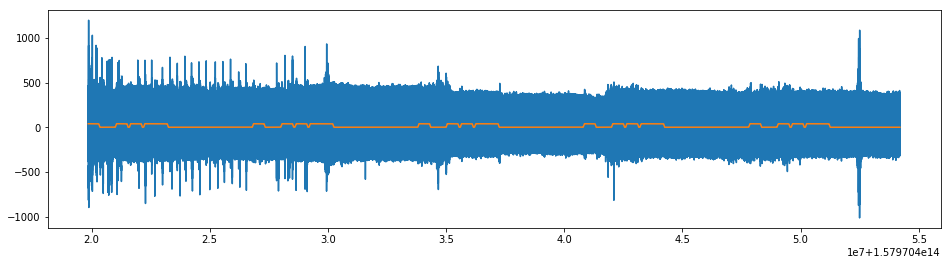

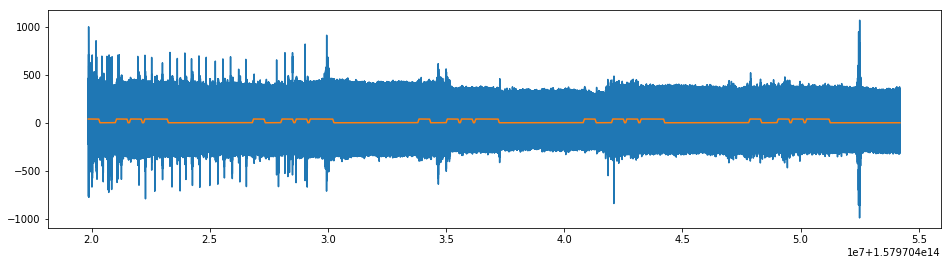

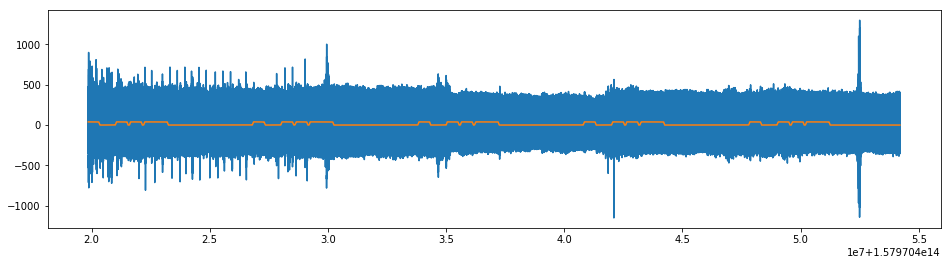

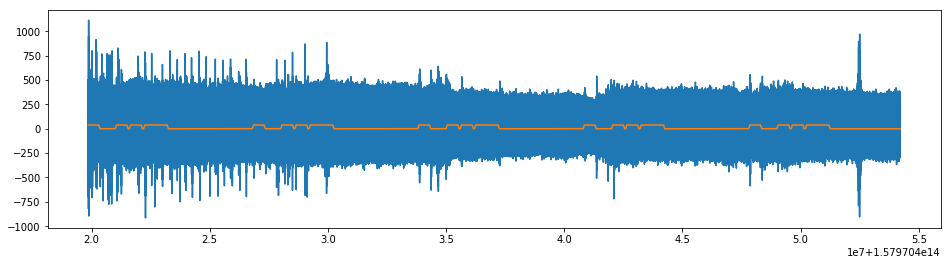

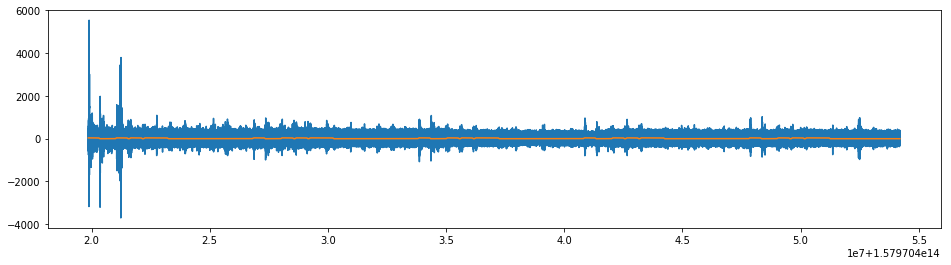

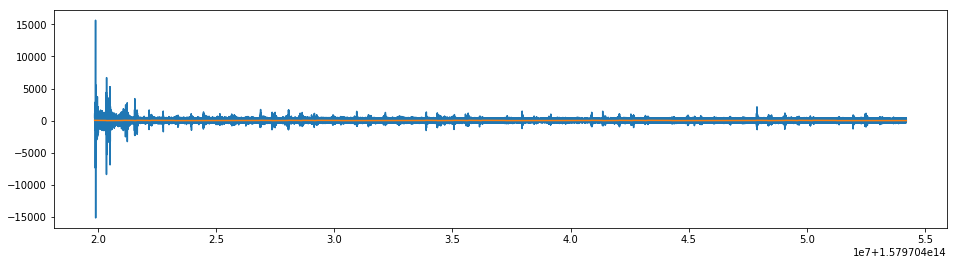

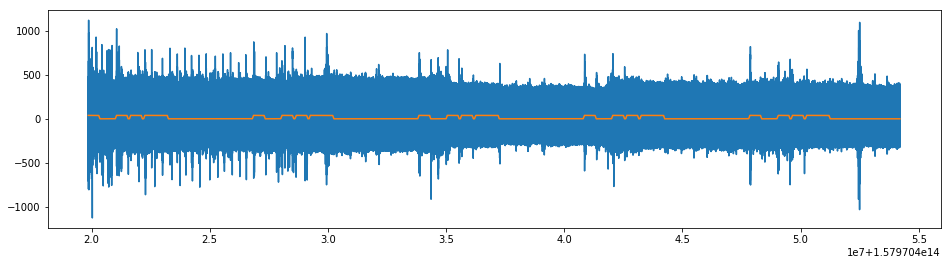

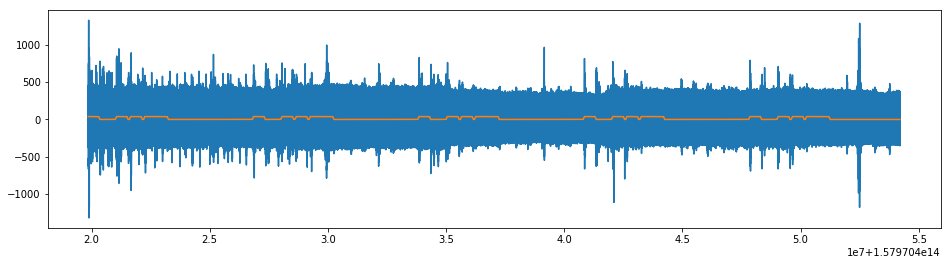

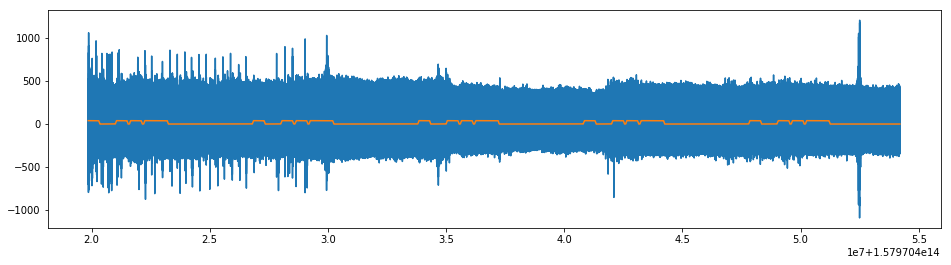

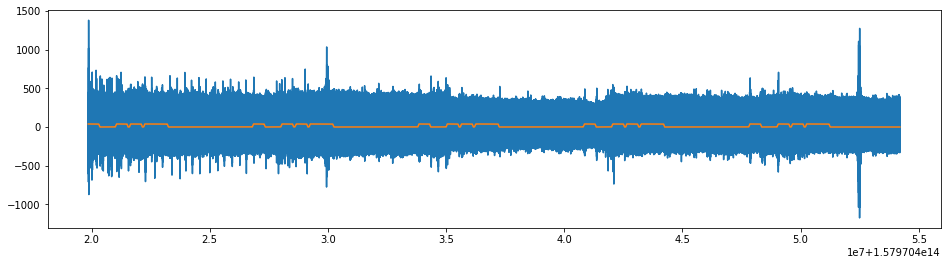

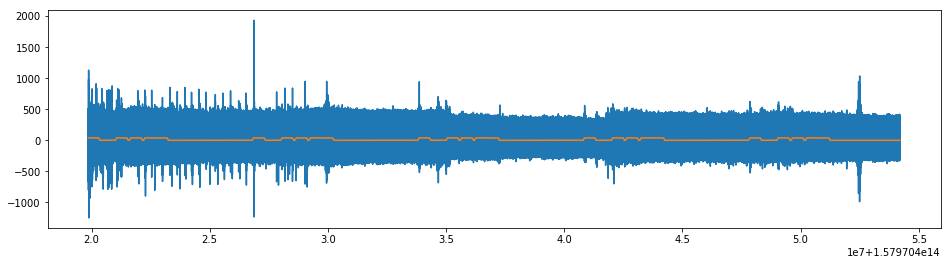

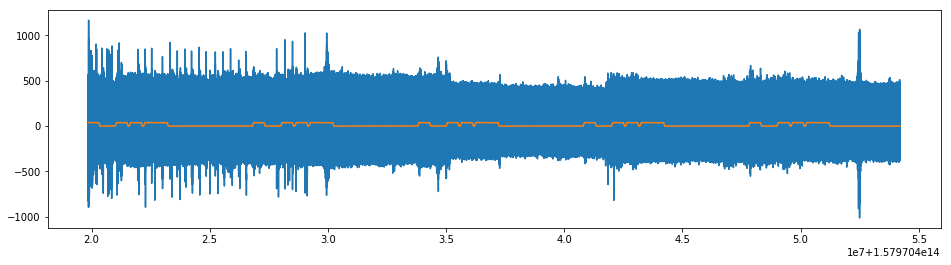

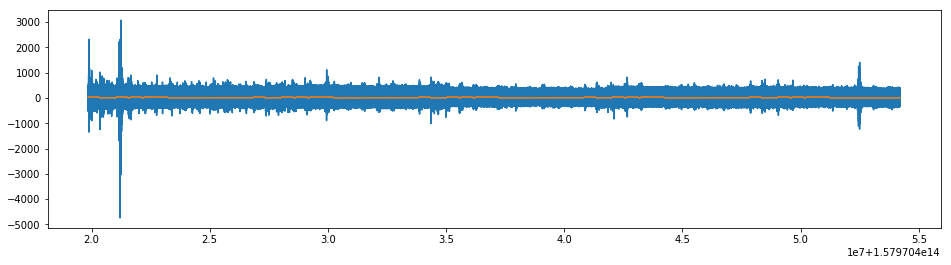

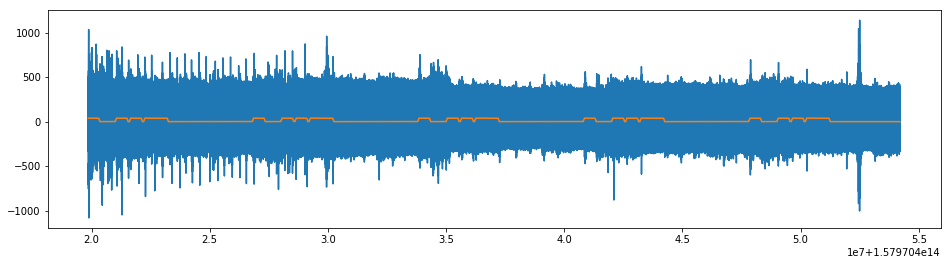

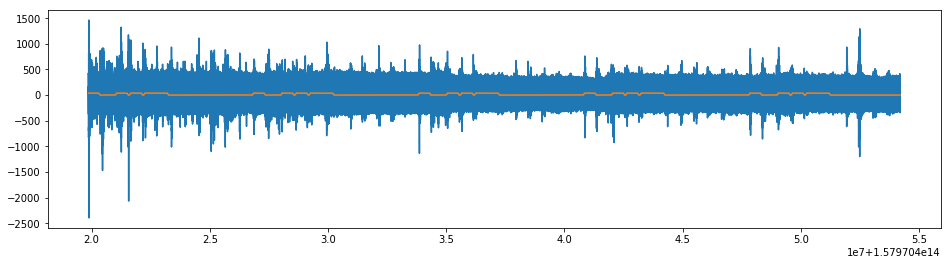

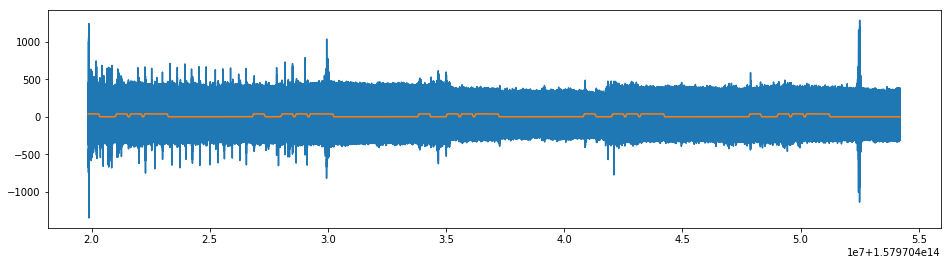

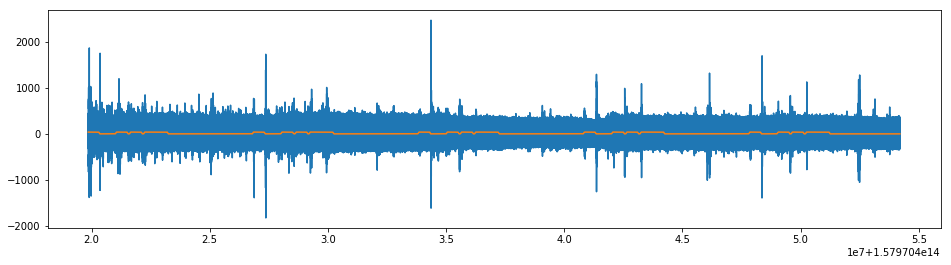

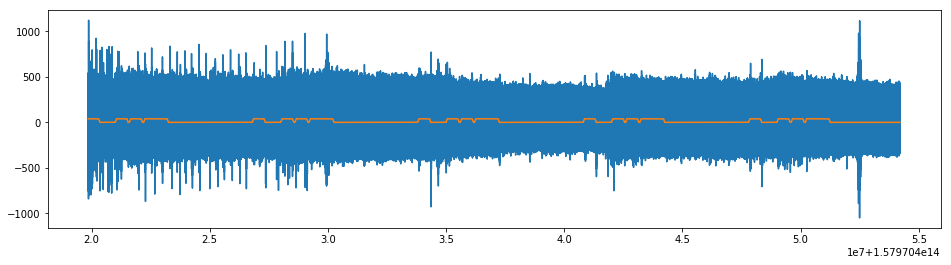

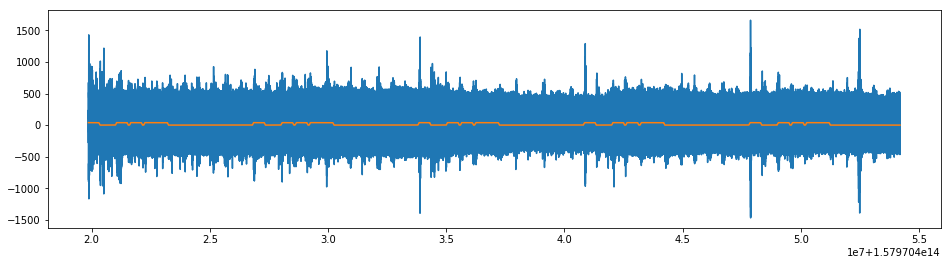

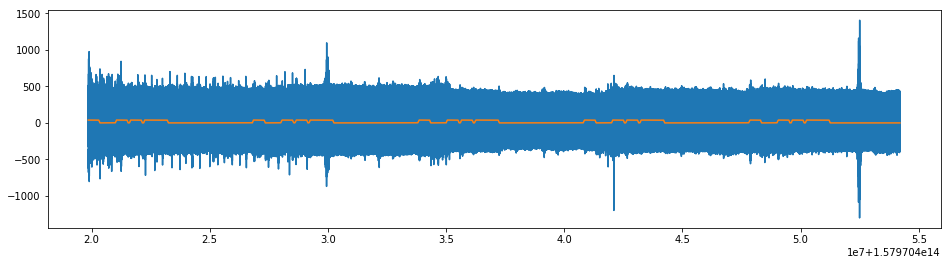

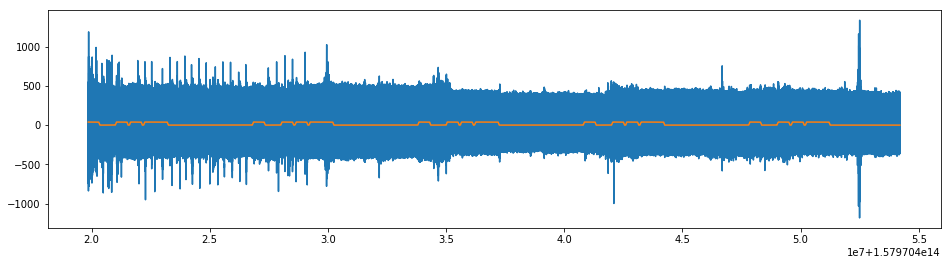

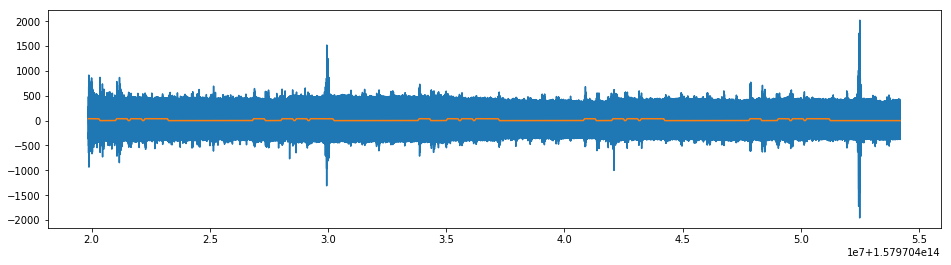

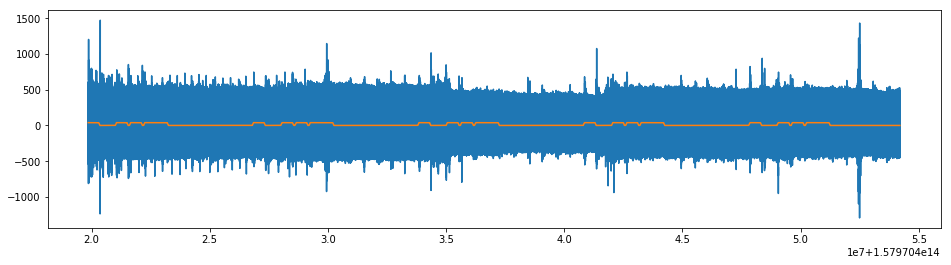

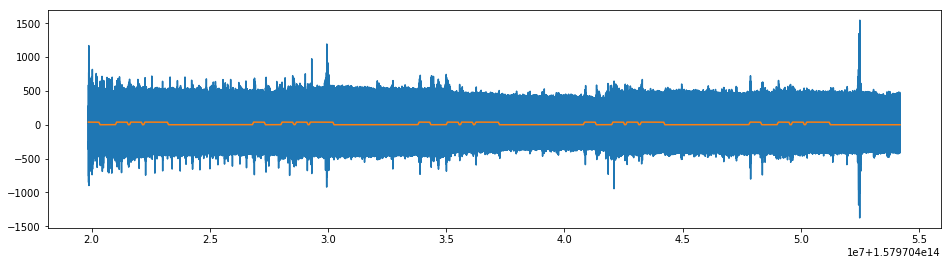

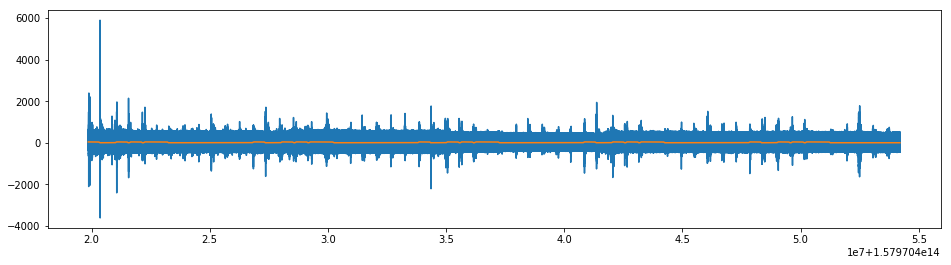

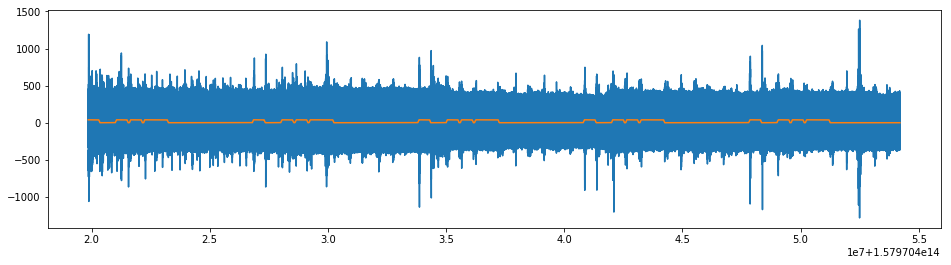

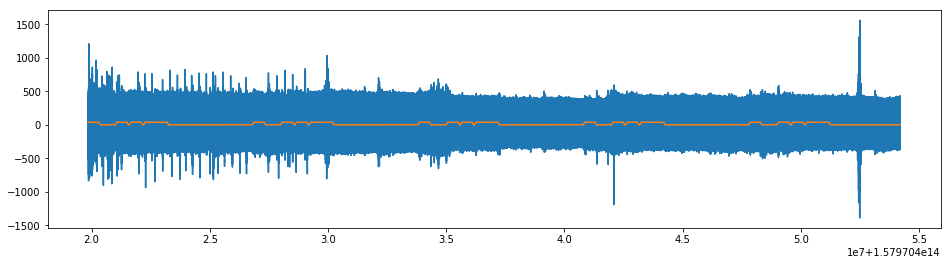

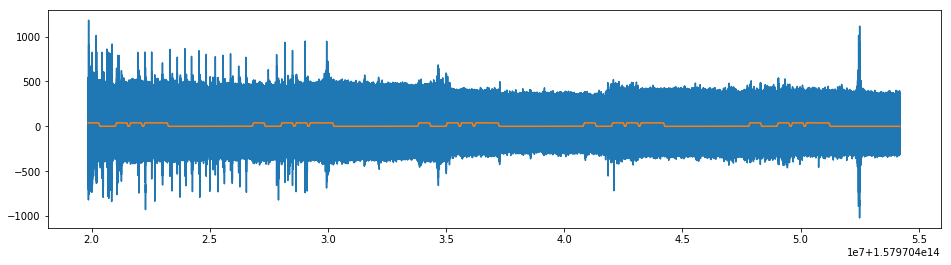

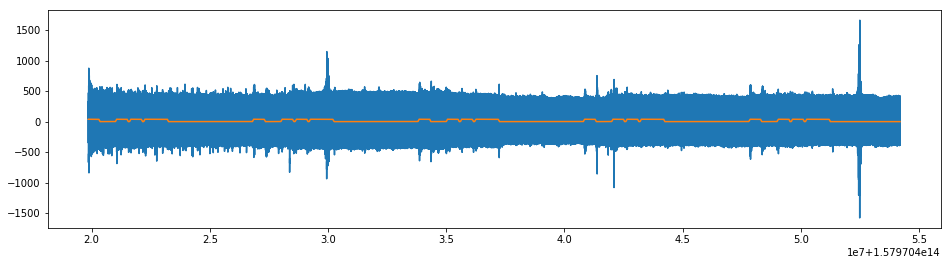

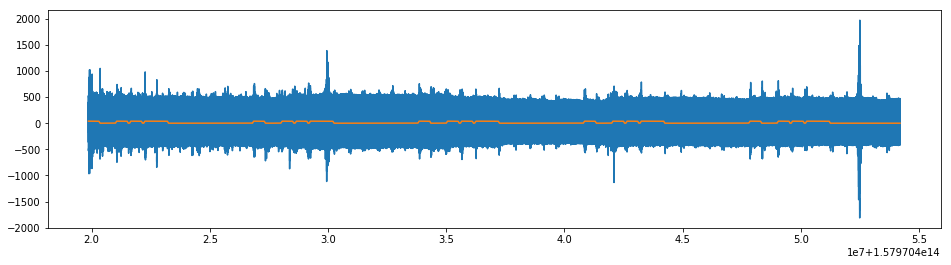

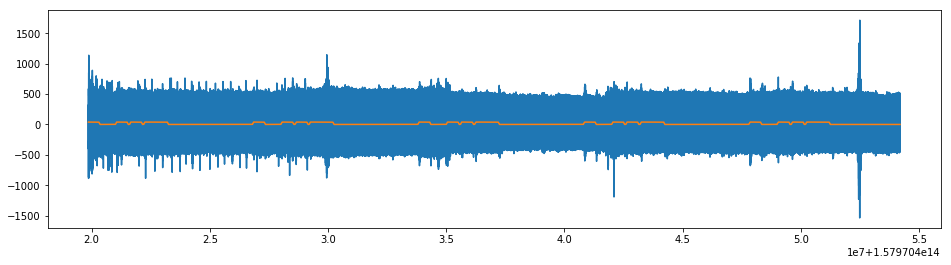

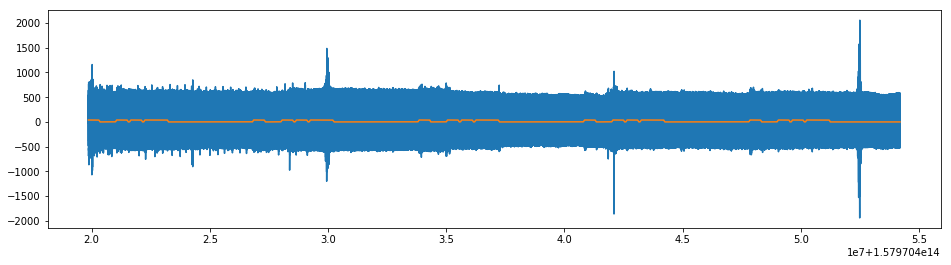

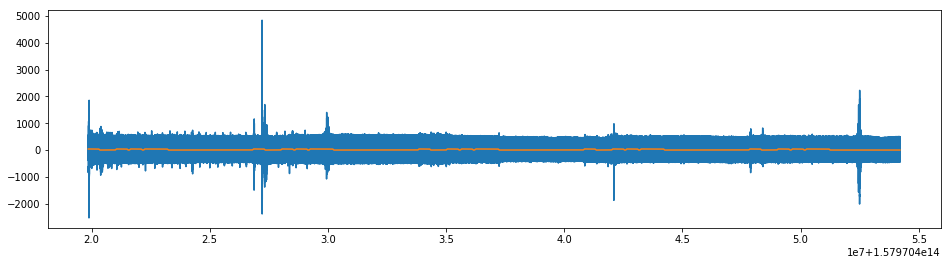

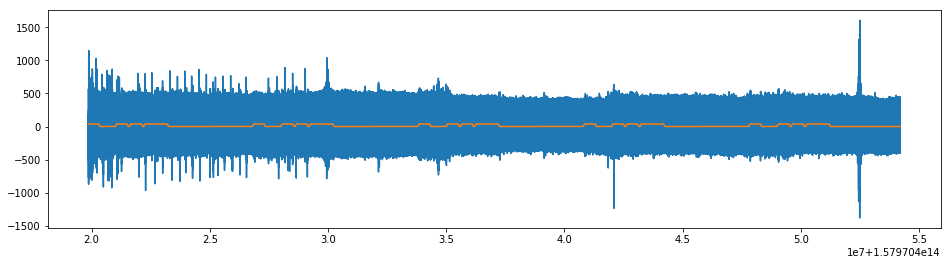

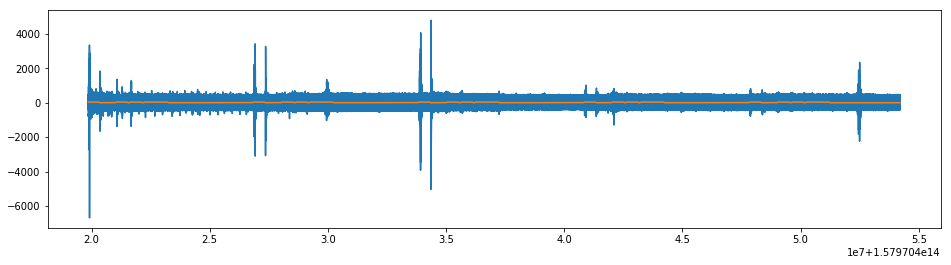

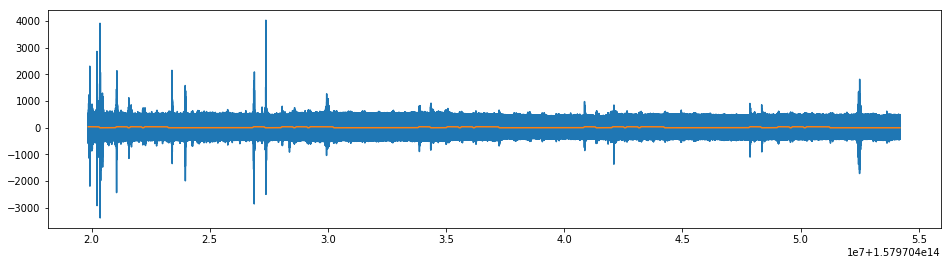

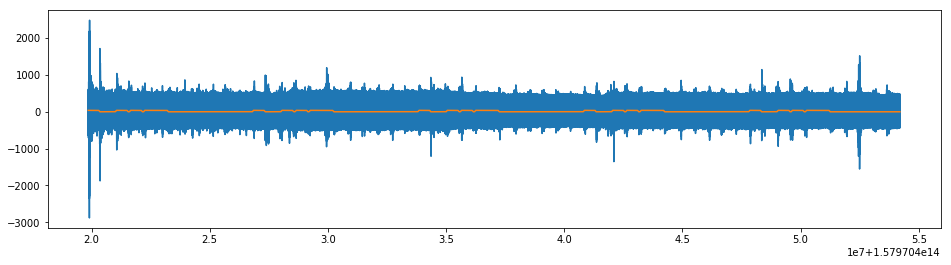

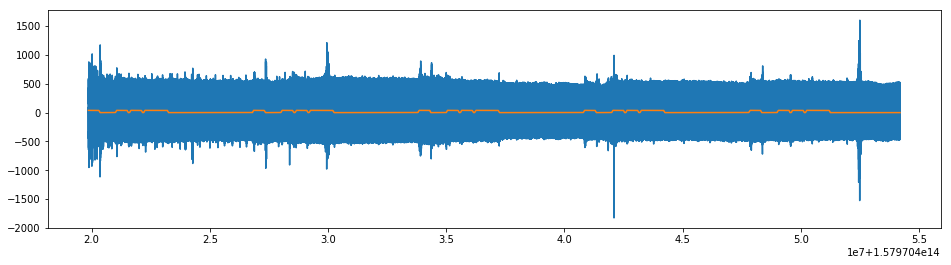

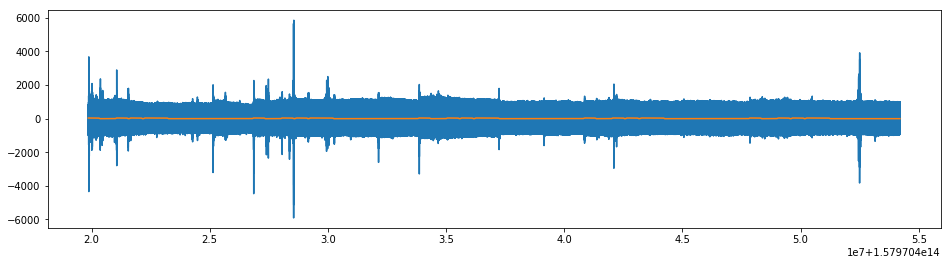

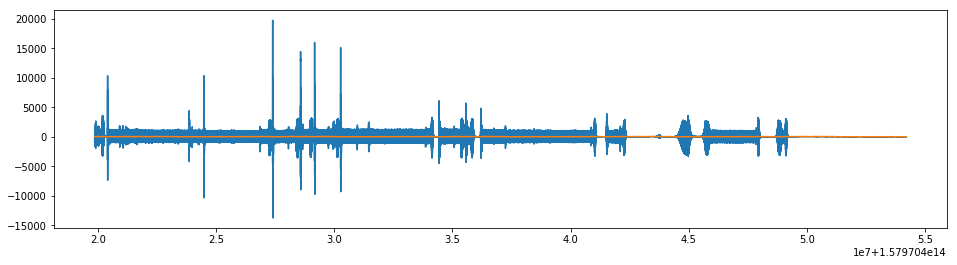

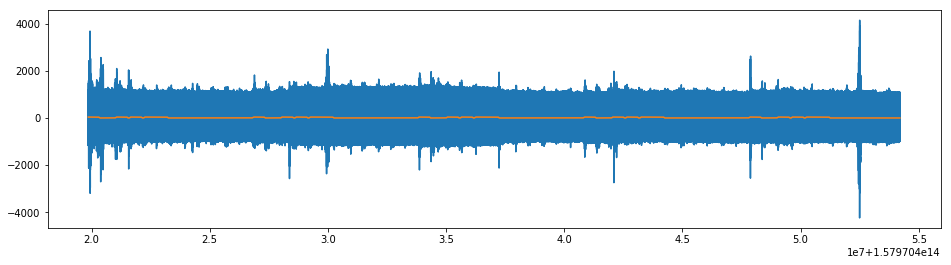

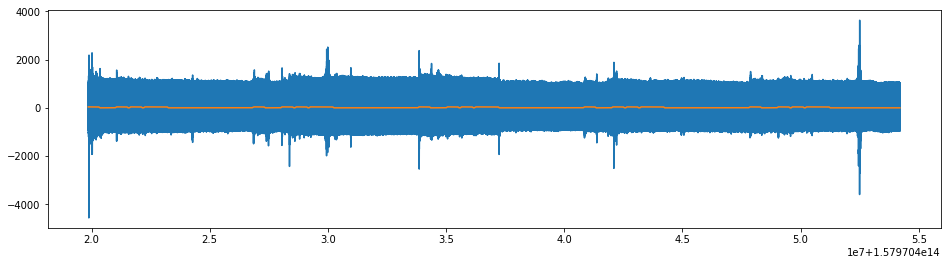

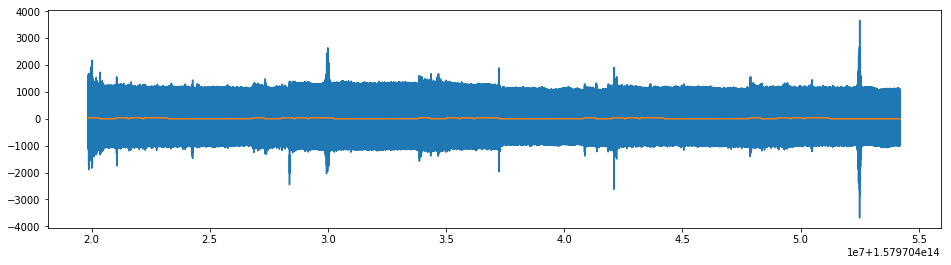

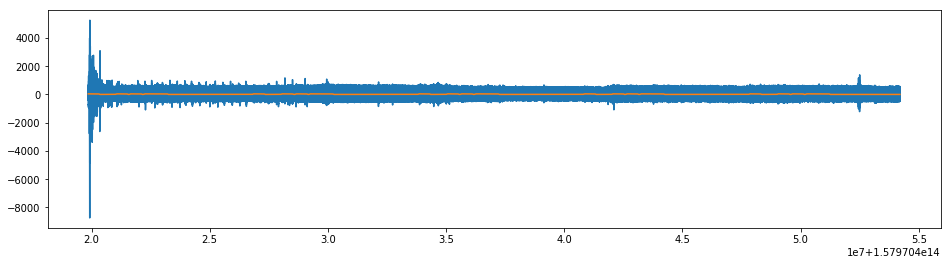

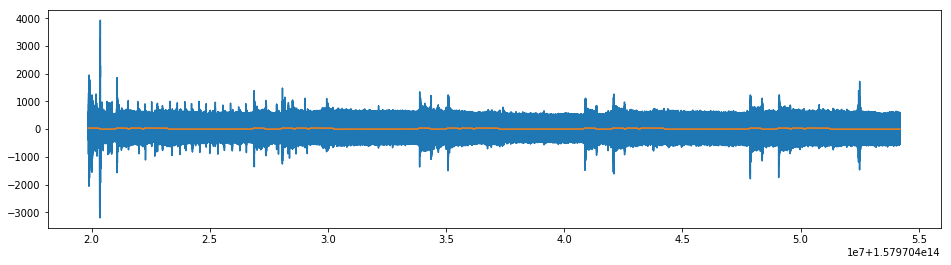

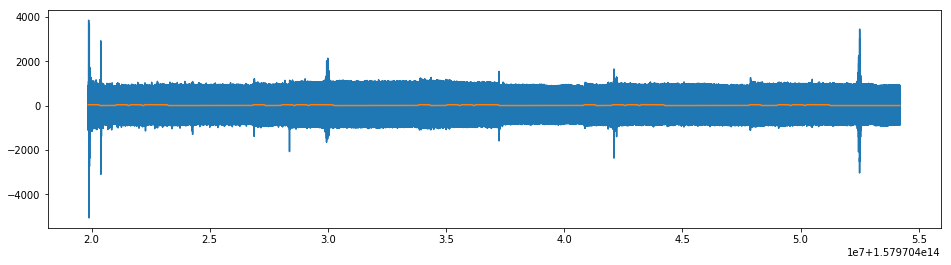

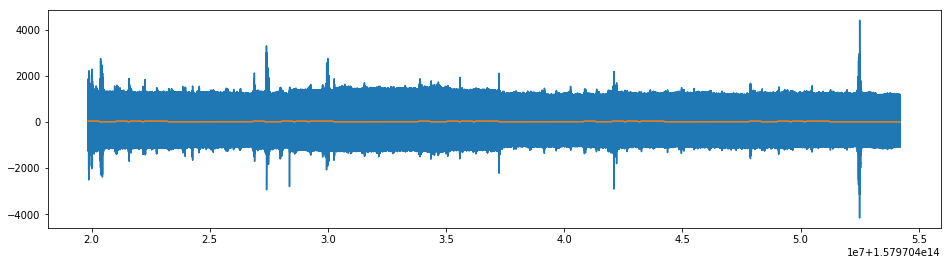

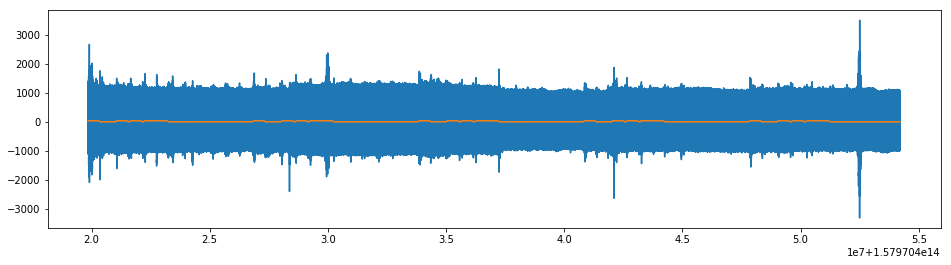

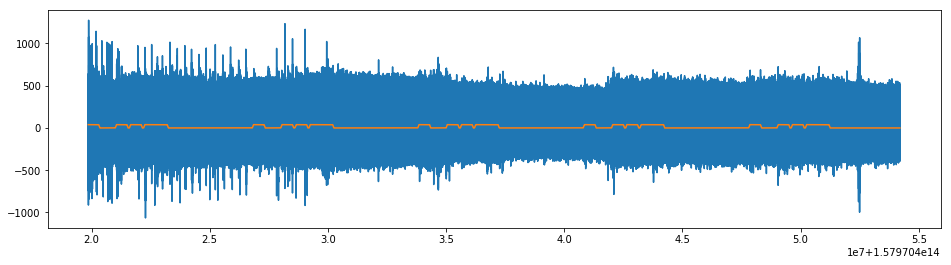

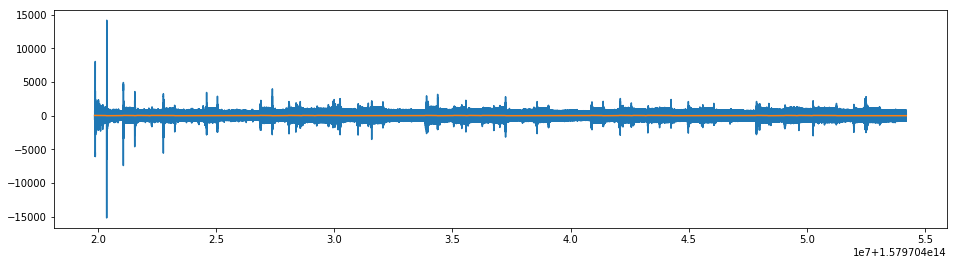

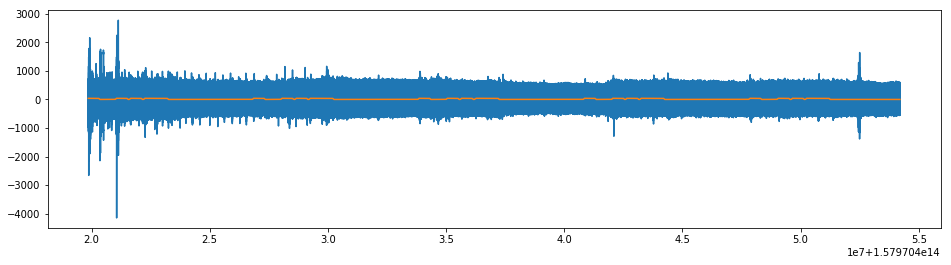

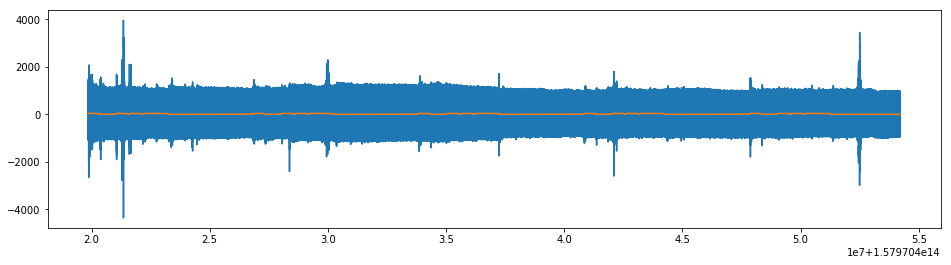

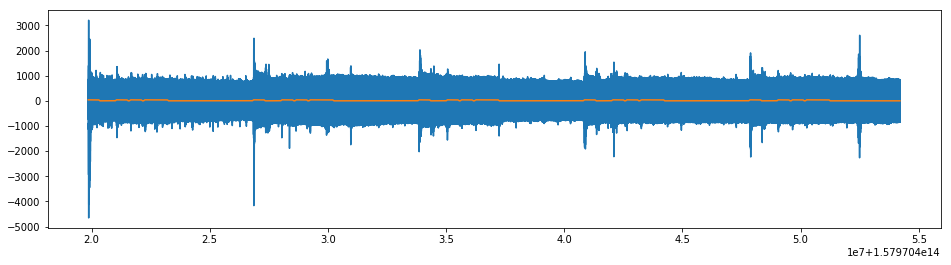

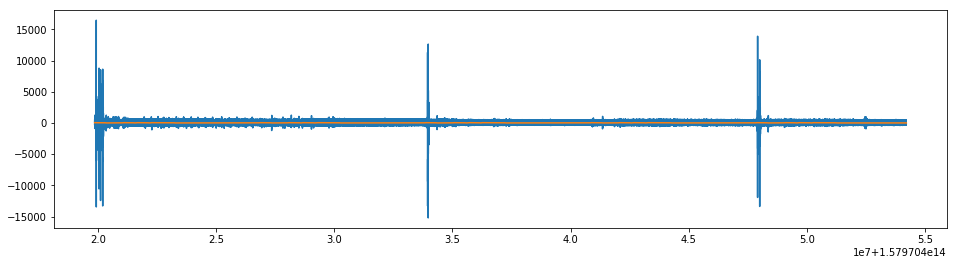

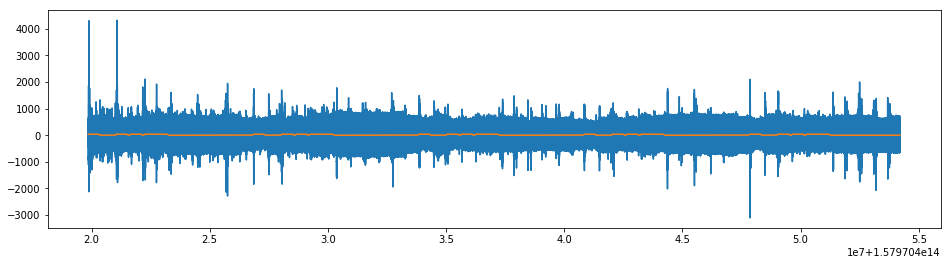

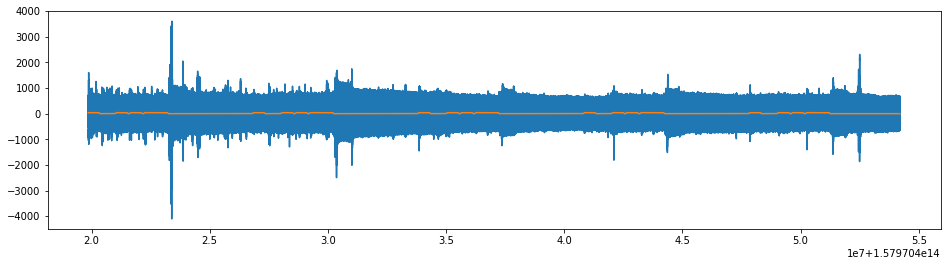

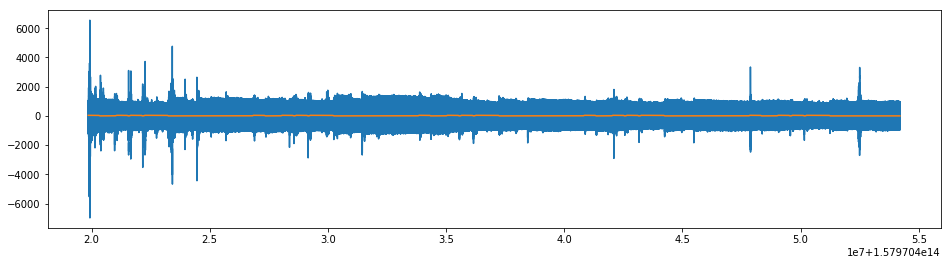

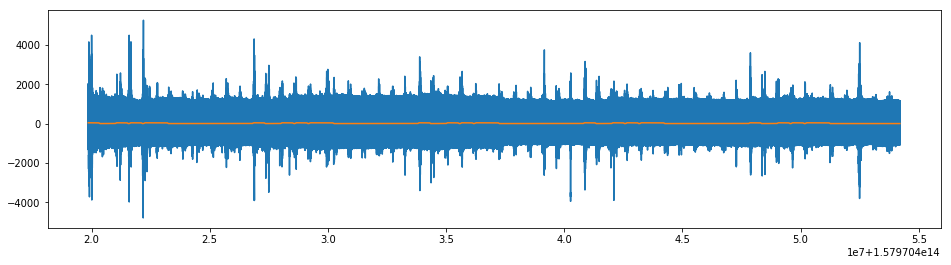

In [14]:
def plt_data(channels,Tables,Labels):
    for stream_channels in channels:
        for i,chans in enumerate(stream_channels):
            plt.figure(figsize = (16,4))
            plt.plot(Tables[0][chans])
            plt.plot(Labels.iloc[:,0])
            plt.show()
    return

plt_data(channels,Tables,Labels)

## Start experiment

Define experiment in other .py with requirements (1 stream for ex), will do stuff related to one specific experiment
cut in a specific way, do what is expected
in the end, the main will be main.py with argument the experiment wanted
in this specific case:

### Preprocessing

In [12]:
#Align targets with 1st stream only, it should be close to the second stream since it will be the same number of windows
print('Align streams and targets')
Tables, Labels = AS.HH_Align(Tables,Labels)

Align streams and targets


In [17]:
#Normalize w/ ref electrode
print('Normalize with reference electrode')
Tables = DPP.H_NormRef_Data(Tables, channels, refs)

Normalize with reference electrode


In [18]:
#Filter notch 50 + 15-500 Hz
print('Filter signal (Bandpass + Notch)')
Tables = DPP.H_filter_data(Tables, FSs, recs)

Filter signal (Bandpass + Notch)


M:\Software\Develop\Webapp_github\The-Awesome-App\Packages\Data_PreProcessing.py:22: UserWarning: The filtering will not work in RT
  warnings.warn('The filtering will not work in RT')


In [20]:
#Cut data
print('Create three sets: train, validation and test')
Tables, Labels = DC.H_Cut_Data_on_percentage(Tables, Labels, val_percentage=1/5, test_percentage=1/5)

Create three sets: train, validation and test


In [21]:
#Standardize (mean=0 and std=1)
print('Standardize channels on train dataset')
Tables, stdscale = DPP.H_standardize_training_data(Tables, recs)

Standardize channels on train dataset


In [22]:
#Standardize based on training set to avoid overfitting
print('Standardize channels on validation and test datasets')
Tables = DPP.H_standardize_val_test_data(Tables, recs, stdscale)

#Windowing
print('Create overlapping time windos')
Train,Val,Test = DPP.H_cut_time_windows(Tables,FSs,win_len/1000,step/1000) #if epoching it will arrive here

#Align targets on windows
print('Align targets on windows')
Train_Labels = AS.H_align_with_windows(Train,Labels)
Val_Labels = AS.H_align_with_windows(Val,Labels)
Test_Labels = AS.H_align_with_windows(Test,Labels)

#Rescale labels to be between 0 and 10, here to avoid having recording, set, and subject
print('Rescale targets')
Train_Labels = DPP.L_scale_labels(Train_Labels,new_max_value = 10)
Test_Labels = DPP.L_scale_labels(Test_Labels,new_max_value = 10)
if not Val_Labels.empty:
    Val_Labels = DPP.L_scale_labels(Val_Labels,new_max_value = 10)

Standardize channels on validation and test datasets
Create overlapping time windos
Align targets on windows
Rescale targets


### Feature Extraction (for standard approach only)

In [23]:
#In this specific case extract features: this will change shape of data
print('Extract Features')
Train, Test, Val = FE.SHFE(Train, Val, Test, feature_names, channels, FSs, online = False, is_parallel = True)

Extract Features
Extract Features of training set
Progression cluster  99.88 %     Exctract Features of testing set
Progression cluster  99.65 %     Exctract Features of validation set
INFO: Feature Extraction Finished         


### Feature Normalization (for standard approach only)

In [24]:
scaler = preprocessing.StandardScaler().fit(Train)
Train.iloc[:,:] = scaler.transform(Train.iloc[:,:])
Test.iloc[:,:] = scaler.transform(Test.iloc[:,:])
if type(Val) != list:
    Val.iloc[:,:] = scaler.transform(Val.iloc[:,:])

### Reshape (Deep approach only)

In [ ]:
#reshape input for DL
#For CNN input needs to be 3d
for i in range(len(Train[0])):
    Train[0][i] = np.expand_dims(Train[0][i].values, axis = -1)

for i in range(len(Val[0])):
    Val[0][i] = np.expand_dims(Val[0][i].values, axis = -1)

for i in range(len(Test[0])):
    Test[0][i] = np.expand_dims(Test[0][i].values, axis = -1)
    
Train[0] = np.array(Train[0])
Val[0] = np.array(Val[0])
Test[0] = np.array(Test[0])

dim1, dim2,_ = Train[0][0].shape
dim_labels = Train_Labels.shape[1]


### Machine Learning

### Training with parameters

In [ ]:
estimator = create_CNN_Ameri_like_model(dim1,dim2,dim_labels, 
                                                nb_conv_1 = 2,
                                                nb_conv_2 = 1,
                                                nb_conv_3 = 0,
                                                nb_conv_4 = 0,
                                                nb_conv_5 = 0,
                                                nb_filter_1 = 32,
                                                nb_filter_2 = 16,
                                                nb_filter_3 = -10,
                                                nb_filter_4 = -10,
                                                nb_filter_5 = -10,
                                                drop_rate = 0,
                                                nb_node_hid1 = 64,
                                                nb_node_hid2 = 0,
                                                _lambda = 0,
                                                gamma = 0.1,
                                                filter_size_x = 3,
                                                filter_size_y = 3,
                                                padding = 'valid')

def step_decay(epoch):
    #We half the the learning rate each 10 epochs
    initial_l_r = 0.02
    drop = 0.5 
    epochs_drop = 10
    lrate = initial_l_r * np.power(drop,np.floor((1 + epoch)/epochs_drop))
    return lrate   
        

lrate_schedule = LearningRateScheduler(step_decay)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=13, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
callbacks_list = [lrate_schedule,early_stopper]

#Train
print('INFO: Start Training')
out = estimator.fit(Train[0],Train_Labels, batch_size = 128, epochs = 1, shuffle=True, validation_data = (Val[0],Val_Labels), callbacks = callbacks_list) 
#estimator.fit(Train[0],Train_Labels, batch_size = 128, epochs = 50, shuffle=True, callbacks = callbacks_list) 


### Parameter search with Genetic Algorithm (Deep Learning)

In [ ]:
now = datetime.now().strftime("%d_%m_%Y_%Hh%Mmin%S")

# Defining the parameters on which we want to iterate
params = {  'nb_conv': [0,1,2,3],
            'nb_filter':[16,32,64,128],
            'drop_rate': [0,0.2,0.5],
            'nb_node_hid1': [16,32,64,128],
            'nb_node_hid2': [0,16,32,64],            
            '_lambda': [0,1e-3,0.1],
            'gamma': [0.1,0.01,0.001],
            'filter_size':[1,3,5],
            'padding':['same','valid']}

def fitness_function(chromosome):
    chromosome = [int(gene) for gene in chromosome]
    print(chromosome)

    #double check
    variables_limits=[(1, 3),(0, 3),(0, 3),(0, 3),(0, 3),(0, 3),(0, 3),(0, 3),(0, 3),(0, 3),(0, 2),(0, 3),(0, 3),(0, 2),(0, 2),(0, 2),(0, 2),(0,1)] 
    for idx, gene in enumerate(chromosome):
      if gene < variables_limits[idx][0] or gene > variables_limits[idx][1]:
        return -99999

    #decode chromosome in params:
    nb_conv_1 = params['nb_conv'][chromosome[0]]
    nb_conv_2 = params['nb_conv'][chromosome[1]]
    nb_conv_3 = params['nb_conv'][chromosome[2]]
    nb_conv_4 = params['nb_conv'][chromosome[3]]
    nb_conv_5 = params['nb_conv'][chromosome[4]]
    nb_filter_1 = params['nb_filter'][chromosome[5]]
    nb_filter_2 = params['nb_filter'][chromosome[6]]
    nb_filter_3 = params['nb_filter'][chromosome[7]]
    nb_filter_4 = params['nb_filter'][chromosome[8]]
    nb_filter_5 = params['nb_filter'][chromosome[9]]
    drop_rate = params['drop_rate'][chromosome[10]]
    nb_node_hid1 = params['nb_node_hid1'][chromosome[11]]
    nb_node_hid2 = params['nb_node_hid2'][chromosome[12]]
    _lambda = params['_lambda'][chromosome[13]]
    gamma = params['gamma'][chromosome[14]]
    filter_size_x = params['filter_size'][chromosome[15]]
    filter_size_y = params['filter_size'][chromosome[16]]
    padding =  params['padding'][chromosome[17]]


    try:
        estimator = create_CNN_Ameri_like_model(dim1,dim2,dim_labels, 
                                                nb_conv_1,
                                                nb_conv_2,
                                                nb_conv_3,
                                                nb_conv_4,
                                                nb_conv_5,
                                                nb_filter_1,
                                                nb_filter_2,
                                                nb_filter_3,
                                                nb_filter_4,
                                                nb_filter_5,
                                                drop_rate,
                                                nb_node_hid1,
                                                nb_node_hid2,
                                                _lambda,
                                                gamma,
                                                filter_size_x,
                                                filter_size_y,
                                                padding)
    except ValueError:
        return -99999

    def step_decay(epoch):
        #We half the the learning rate each 10 epochs
        initial_l_r = gamma
        drop = 0.5 
        epochs_drop = 10
        lrate = initial_l_r * np.power(drop,np.floor((1 + epoch)/epochs_drop))
        return lrate   


    lrate_schedule = LearningRateScheduler(step_decay)
    early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=13, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    callbacks_list = [lrate_schedule,early_stopper]

    #Train
    print('INFO: Start Training')
    out = estimator.fit(Train[0],Train_Labels, batch_size = 512, epochs = 50, shuffle=True, validation_data = (Val[0],Val_Labels), callbacks = callbacks_list) 

    history =  [out.history['loss'][-1], out.history['val_loss'][-1]] + chromosome
    history_df = pd.DataFrame([history])
    history_df.to_csv('GS_sEMG_AmeriLike_{}_{}.csv'.format(recs,now),mode='a', header=False)

    return -out.history['val_loss'][-1]

from geneal.genetic_algorithms import ContinuousGenAlgSolver
from geneal.applications.fitness_functions.continuous import fitness_functions_continuous

solver = ContinuousGenAlgSolver(
    n_genes=18, 
    fitness_function=fitness_function,
    pop_size=20,
    max_gen=200,
    mutation_rate=0.1,
    selection_rate=0.6,
    selection_strategy="roulette_wheel",
    problem_type=int, # Defines the possible values as float numbers
    #variables in order:
    #nb conv 1,2,3,4,5, nb filter 1,2,3,4,5, drop rate, nb node hid1, hid2, lambda,gamma, x,y
    variables_limits=[(1, 3),(0, 3),(0, 3),(0, 3),(0, 3),(0, 3),(0, 3),(0, 3),(0, 3),(0, 3),(0, 2),(0, 3),(0, 3),(0, 2),(0, 2),(0, 2),(0, 2),(0,1)] 
                            # Defines the limits of all variables between -10 and 10. 
                            # Alternatively one can pass an array of tuples defining the limits
                            # for each variable: [(-10, 10), (0, 5), (0, 5), (-20, 20)]
)

solver.solve()



### Parameter search with Genetic Algorithm (Standard approach)

In [ ]:
now = datetime.now().strftime("%d_%m_%Y_%Hh%Mmin%S")

# Defining the parameters on which we want to iterate
params = {  'nb_nodes': [0,16,32,64,128,256],
            'drop_rate':[0,0.2,0.5],
            'L1': [0,1e-3,0.1],
            'L2': [0,1e-3,0.1],
            'gamma': [0.1,0.01,0.001],
            'optimizer':[tf.keras.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.SGD]}

def fitness_function(chromosome):
    chromosome = [int(chromosom) for chromosom in chromosome]
    print(chromosome)

    #double check
    variables_limits=[(1, 5),(0, 5),(0, 5),(0, 2),(0, 2),(0, 2),(0, 2),(0, 2)] + [(0,1)]*90 
    for idx, gene in enumerate(chromosome):
        if gene < variables_limits[idx][0] or gene > variables_limits[idx][1]:
            return -99999


    #decode chromosome in params:
    nb_nodes_1 = params['nb_nodes'][chromosome[0]]
    nb_nodes_2 = params['nb_nodes'][chromosome[1]]
    nb_nodes_3 = params['nb_nodes'][chromosome[2]]
    drop_rate = params['drop_rate'][chromosome[3]]
    L1 = params['L1'][chromosome[4]]
    L2 = params['L2'][chromosome[5]]
    gamma = params['gamma'][chromosome[6]]
    optimizer = params['optimizer'][chromosome[7]]

    Optim = optimizer(learning_rate=gamma)

    #Feature selection
    input_shape = [np.sum(chromosome[8:])]


    try:
        estimator = create_mlp(input_shape, task_type = 'Regression', drop_rate = drop_rate, nb_nodes_1 = nb_nodes_1, nb_nodes_2 = nb_nodes_2, nb_nodes_3 = nb_nodes_3, optimizer = Optim, Nb_outputs = 6 ,nclass = None, L1 = L1, L2 = L2)
    except ValueError:
        return -99999

    def step_decay(epoch):
        #We half the the learning rate each 10 epochs
        initial_l_r = gamma
        drop = 0.5 
        epochs_drop = 10
        lrate = initial_l_r * np.power(drop,np.floor((1 + epoch)/epochs_drop))
        return lrate   


    lrate_schedule = LearningRateScheduler(step_decay)
    early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=13, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks_list = [lrate_schedule,early_stopper]

    #Train
    print('INFO: Start Training')
    out = estimator.fit(Train.iloc[:,[i for i, e in enumerate(chromosome[8:]) if e != 0]],Train_Labels, batch_size = 64, epochs = 50, shuffle=True, validation_data = (Val.iloc[:,[i for i, e in enumerate(chromosome[8:]) if e != 0]],Val_Labels), callbacks = callbacks_list, verbose = 0) 
    #512

    history =  [out.history['loss'][-1], out.history['val_loss'][-1]] + chromosome
    history_df = pd.DataFrame([history])
    history_df.to_csv('GS_sEMG_Standard_{}_{}.csv'.format(recs,now),mode='a', header=False)

    return -out.history['val_loss'][-1]

from geneal.genetic_algorithms import ContinuousGenAlgSolver


solver = ContinuousGenAlgSolver(
    n_genes=98, 
    fitness_function=fitness_function,
    pop_size=20,
    max_gen=200,
    mutation_rate=0.1,
    selection_rate=0.6,
    selection_strategy="roulette_wheel",
    problem_type=int, # Defines the possible values as float numbers
    #variables in order:
    #nb_nodes1,2,3,L1,L2,gamma,optimizer
    variables_limits=[(1, 5),(0, 5),(0, 5),(0, 2),(0, 2),(0, 2),(0, 2),(0, 2)] + [(0,1)]*90 
                            # Defines the limits of all variables between -10 and 10. 
                            # Alternatively one can pass an array of tuples defining the limits
                            # for each variable: [(-10, 10), (0, 5), (0, 5), (-20, 20)]
)

solver.solve()

# Performances

In [ ]:
# Predicting with the best model
pred_test_loss =  estimator.estimate(Test)

# Predicting with the best model also on train 
pred_train_loss =  estimator.estimate(Train)

# Predicting with the best model also on Val
pred_val_loss =  estimator.estimate(Val)

In [32]:
# Predicting with the best model
pred_test_model =  estimator.predict(Test)

# Predicting with the best model also on train 
pred_train_model =  estimator.predict(Train)

# Predicting with the best model also on Val
pred_val_model =  estimator.predict(Val)

Plots: